In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import cvxpy as cp
import numpy as np

In [2]:
def create_MDP1():
    # create the state map
    S = np.arange(10*10).reshape(10,10).T
    
    # create the corresponding reward functions
    R = np.zeros((10,10))
    R[9,9] = 1
    
    return (S,R)

In [3]:
def create_MDP2():
    # create the state map
    S = np.arange(10*10).reshape(10,10).T
    
    # create the corresponding reward functions
    R = np.zeros((10,10))
    R[1:7,4] = -100
    R[3:8,8] = -100
    R[1,5:7] = -100
    R[1:4,6] = -100
    R[3,7] = -100
    R[7:9,6] = -100
    R[7,7] = -100
    R[9,9] = 10

    return (S,R)

In [4]:
def create_heatmap(X,title="Empty"):
    c = plt.pcolor(X,cmap='RdBu',edgecolors='k',linewidths=4)
    plt.gca().invert_yaxis()
    plt.title("Reward 1 Heatmap")
    plt.colorbar()
    plt.show()

In [5]:
def create_rewardmap(X,title="Empty"):
    plt.figure(figsize=(10,10))
    plt.pcolor(np.zeros((10,10)) , cmap='gray',edgecolors='white',linewidth=4)
    for i in np.arange(10):
        for j in np.arange(10):
            plt.text(j+0.5,i+0.5,"{:.3f}".format(float(X[i,j])),color='white',size=10,ha='center', va='center',weight='bold')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.axis('equal')

In [6]:
def create_policymap(policy,title="Empty"):
    plt.figure(figsize=(10,10))
    plt.pcolor(np.zeros((10,10)) , cmap='gray',edgecolors='white',linewidth=4)
    selections = np.array(['\u2190','\u2191','\u2192','\u2193'])
    for i in np.arange(10):
        for j in np.arange(10):
            plt.text(j+0.5,i+0.5,selections[int(policy[i,j])],color='white',size=30,ha='center', va='center',weight='bold')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.axis('equal')

In [7]:
def value_iteration(environment,threshold,discount_factor):
    S = environment.state_space

    V = np.zeros(S.shape); delta = 1
    while delta > threshold:
        delta = 0
        for s in S.ravel():
            x,y = np.where(S==s)
            v = V[x,y]
            Vs = np.zeros((4,))
            for a in np.arange(N_actions):
                states,rewards,p,coordinates = environment.get_transitions(s,a)
                x_,y_ = zip(*coordinates)
                Vs[a] = np.sum(p*(rewards + discount_factor*V[x_,y_]))

            best_action = np.argmax(Vs) 
                
            delta = max(delta,np.abs(Vs[best_action] - v))
            V[x,y] = Vs[best_action]
            
    # compute the optimal policy based on the value iteration
    policy = np.zeros(S.shape)
    for s in S.ravel():
        x,y = np.where(S==s)
        Vs = np.zeros((4,))
        for a in np.arange(N_actions):
            states,rewards,p,coordinates = environment.get_transitions(s,a)
            x_,y_ = zip(*coordinates)
            Vs[a] = np.sum(p*(rewards + discount_factor*V[x_,y_]))

        policy[x,y] = np.argmax(Vs) 

            
    return V,policy

In [8]:
class RL_environment:
    def __init__(self,S,R,A,w):
        self.state_space = S
        self.reward_space = R
        self.N_actions = A
        self.w = w
        
    def step(self,current_state,action):
        x,y = np.where(self.state_space==current_state)
        p = np.array([self.w/4]*self.N_actions)
        p[action] = p[action] + 1-self.w
        
        # action is random to extent ...
        action = np.random.choice(self.N_actions,p=p)
        
        if action == 0:
            y = max(y-1,0)
        elif action == 1:
            x = max(x-1,0)
        elif action == 2:
            y = min(y+1,9)
        else: 
            x = min(x+1,9)
            
        x = int(x); y = int(y)
        return self.state_space[x,y],self.reward_space[x,y]
    
    def get_transitions(self,current_state,action):
        """
        returns states, rewards, probabilities, coordinates for all non-zero states
        """
        p = np.array([self.w/4]*self.N_actions)
        p[action] = p[action] + 1-self.w
        states = np.zeros((4,))
        rewards = np.zeros((4,))
        coordinates = []
        
        for a in np.arange(self.N_actions):
            
            x,y = np.where(self.state_space==current_state)
            
            if a == 0:
                y = max(y-1,0)
            elif a == 1:
                x = max(x-1,0)
            elif a == 2:
                y = min(y+1,9)
            else: 
                x = min(x+1,9)
                
            x = int(x); y = int(y)
                
            states[a] = self.state_space[x,y]
            rewards[a] = self.reward_space[x,y]
            coordinates.append((x,y))
        return states,rewards,p,coordinates
    
    def get_transition_probabiliy_vector(self,current_state,action):
        num_states = np.prod(self.state_space.shape)
        P = np.zeros((1,num_states))
        states,rewards,probs,indices = self.get_transitions(current_state,int(action))
        flat_indices = np.ravel_multi_index(list(zip(*indices)),dims=self.state_space.shape)
        for j,idx in enumerate(flat_indices):
            P[0,idx] +=  probs[j]
        
        return P

In [9]:
"""
num_states = np.prod(S1.shape)
P_optimal = np.zeros((num_states,num_states))

for i,(s,o) in enumerate(zip(S1.ravel(),policy1.ravel().astype(np.int))):
    states,rewards,probs,indices = environment2.get_transitions(s,o)
    flat_indices = np.ravel_multi_index(list(zip(*indices)),dims=S1.shape)
    P_optimal[i,flat_indices] = probs 
    
R_max = np.max(R1)
"""

'\nnum_states = np.prod(S1.shape)\nP_optimal = np.zeros((num_states,num_states))\n\nfor i,(s,o) in enumerate(zip(S1.ravel(),policy1.ravel().astype(np.int))):\n    states,rewards,probs,indices = environment2.get_transitions(s,o)\n    flat_indices = np.ravel_multi_index(list(zip(*indices)),dims=S1.shape)\n    P_optimal[i,flat_indices] = probs \n    \nR_max = np.max(R1)\n'

# PART 1

## Question 1

In [10]:
S1,R1 = create_MDP1()

In [11]:
S2,R2 = create_MDP2()

## Question 2

In [12]:
w = .1
N_actions = 4
discount_factor = 0.8

environment1 = RL_environment(S1,R1,N_actions,w)

In [13]:
threshold = 1e-2; 
V1,policy1 = value_iteration(environment1,threshold,discount_factor)

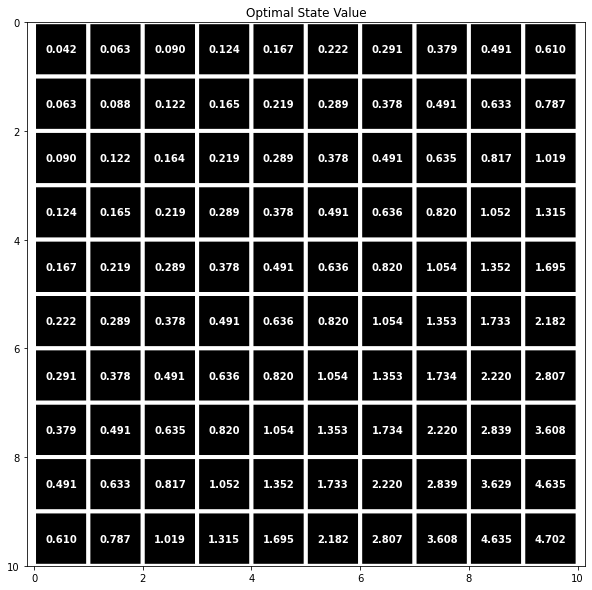

In [14]:
create_rewardmap(V1,"Optimal State Value")

## Question 3

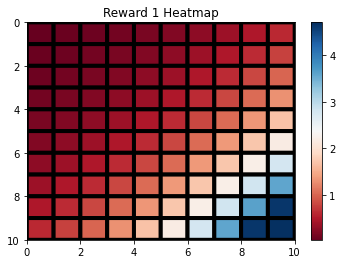

In [15]:
create_heatmap(V1,title="Optimal State Value Heatmap")

## Question 4

C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


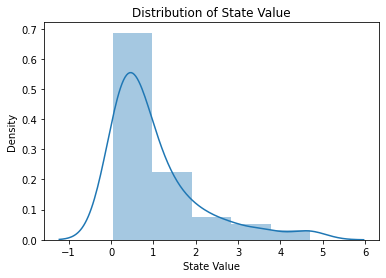

In [16]:
sns.distplot(V1.ravel(),bins=5)
plt.xlabel("State Value"); plt.title("Distribution of State Value");
plt.show()

## Question 5

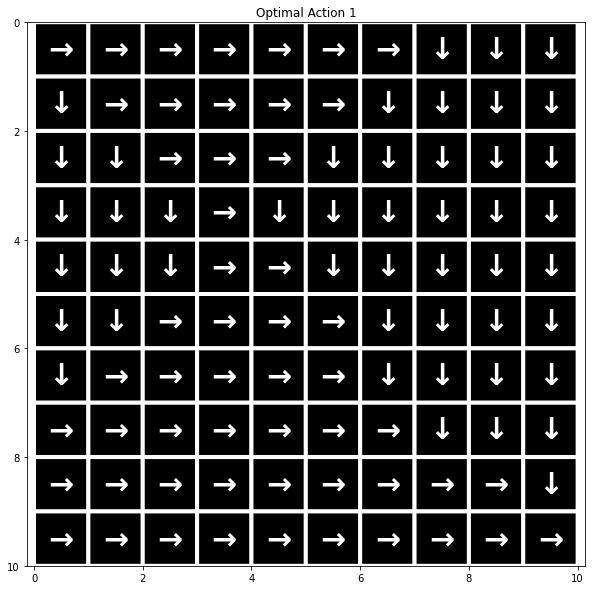

In [17]:
create_policymap(policy1,title="Optimal Action 1")

## Question 6

In [18]:
w = .1
N_actions = 4
discount_factor = 0.8

environment2 = RL_environment(S2,R2,N_actions,w)

In [19]:
threshold = 1e-2
V2,policy2 = value_iteration(environment2,threshold,discount_factor)

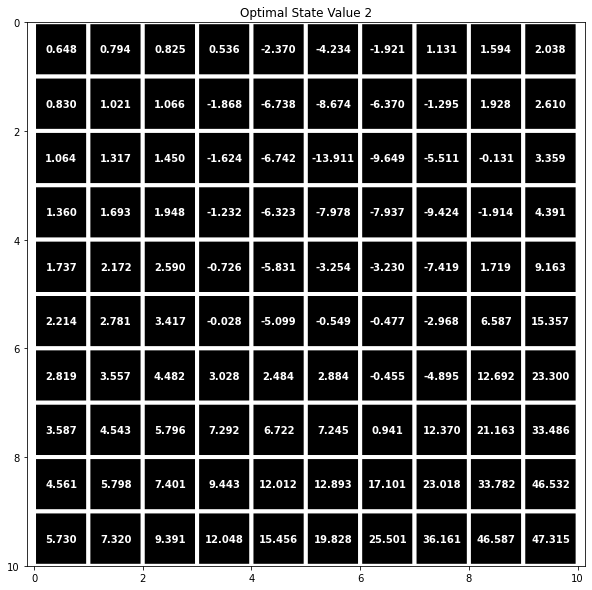

In [20]:
create_rewardmap(V2,title="Optimal State Value 2")

## Question 7

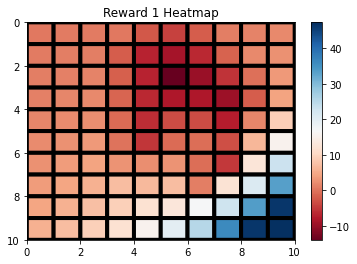

In [21]:
create_heatmap(V2,"Optimal State Value 2 Heatmap")

## Question 8 

C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


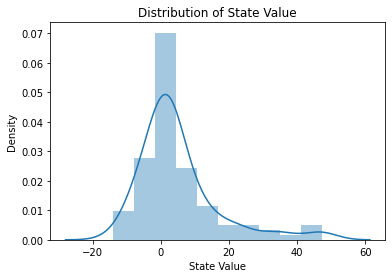

In [22]:
sns.distplot(V2.ravel(),bins=10)
plt.xlabel("State Value"); plt.title("Distribution of State Value");
plt.show()

## Question 9

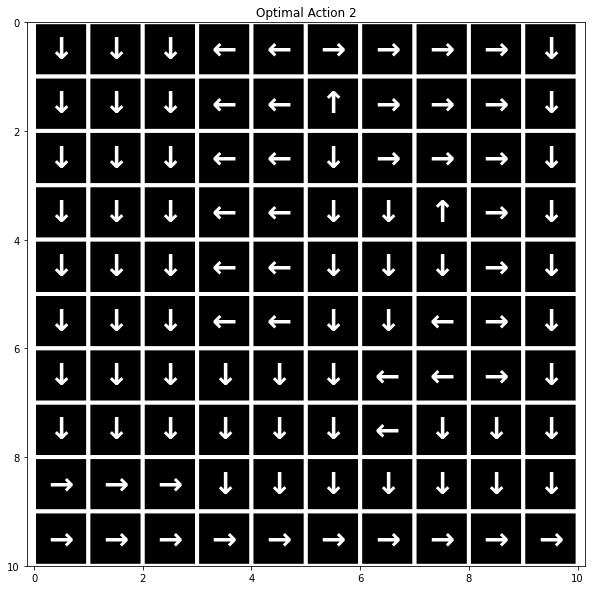

In [23]:
create_policymap(policy2,"Optimal Action 2")

# PART 2

In [24]:
def get_optimal_policy_transition_matrix(environment,policy):
    num_states = np.prod(environment.state_space.shape)
    P_optimal = np.zeros((num_states,num_states))
    for i,(s,o) in enumerate(zip(environment.state_space.ravel(),policy.ravel().astype(np.int))):
        P_optimal[i,:] = environment.get_transition_probabiliy_vector(s,o)
    
    return P_optimal

In [31]:
def get_same_action_policy_transition_matrices(environment):
    P_As = []
    num_states = np.prod(environment.state_space.shape)

    for a in np.arange(environment.N_actions):
        P_As.append(np.zeros((num_states,num_states)))
        for i,s in enumerate(environment.state_space.ravel()):
            P_As[a][i,:] = environment.get_transition_probabiliy_vector(s,a)
            
    return P_As

In [54]:
def get_b_D_block_matrices(environment,discount_factor,policy,p_optimal,p_as):
    R_max = environment.reward_space.max()
    num_states = np.prod(environment.state_space.shape)

    # create b vector
    zero_column = np.zeros((num_states,1))
    ones_column = np.ones((num_states,1))

    b = np.vstack(( 
                   zero_column , 
                    zero_column,
                   zero_column,
                   zero_column,
                   R_max *ones_column,
                   R_max * ones_column)
        )
    
    Ds = []
    
    zero_block = np.zeros((num_states,num_states))
    identity = np.eye(num_states)
    
    for a in np.arange(environment.N_actions):
        special_delete = np.eye(num_states)
        special_delete[policy.ravel()==a] = 0 
        block_matrix = p_optimal-p_as[a]
        block_matrix[policy.ravel()==a] = 0
        
        row1 = np.hstack((
                          -np.matmul(block_matrix,np.linalg.inv(np.eye(num_states)-discount_factor*p_optimal)),    
                           zero_block,
                           special_delete
                            ))

        row2 = np.hstack((
                          -np.matmul(P_optimal-P_As[a],np.linalg.inv(identity-discount_factor*P_optimal)),    
                           zero_block,
                           zero_block
                            ))

        row3 = np.hstack((
                           -identity,
                           -identity,
                           zero_block
                            ))

        row4 = np.hstack((
                           identity,
                           -identity,
                           zero_block
                            ))

        row5 = np.hstack((
                           identity,
                           zero_block,
                          zero_block      
                            ))

        row6 = np.hstack((
                           -identity,
                           zero_block,
                          zero_block       
                            ))

        Ds.append(np.vstack((row1,row2,row3,row4,row5,row6)))
        
    return b,Ds

In [55]:
def get_c_block_matrices(environment,lambda1):
    R_max = environment.reward_space.max()
    num_states = np.prod(environment.state_space.shape)

    # create b vector
    zero_column = np.zeros((num_states,1))
    ones_column = np.ones((num_states,1))   
    
    c= np.vstack(( 
        zero_column , 
        -lambda1 * ones_column,
        ones_column
        ))
    
    return c
    

In [56]:
def linear_solve_IRL(environment,b,c,Ds):
    np.random.seed(1)
    num_states = np.prod(environment.state_space.shape)

    # Construct the problem.
    x = cp.Variable(shape=(3*num_states,1))

    objective = cp.Maximize(c.T@x)
    constraints = [Ds[a]@x <= b for a in np.arange(environment.N_actions)]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    # The optimal value for x is stored in `x.value`.
    return x.value[:num_states]

In [57]:
R_max = environment1.reward_space.max()

In [58]:
P_optimal = get_optimal_policy_transition_matrix(environment1,policy1)

In [59]:
P_As = get_same_action_policy_transition_matrices(environment1)

In [60]:
b,Ds = get_b_D_block_matrices(environment1,discount_factor,policy1,P_optimal,P_As)

In [61]:
from tqdm import tqdm

In [62]:
IRL_1_accuracy = []
for lambda1 in tqdm(np.linspace(0,5,500)):
    c = get_c_block_matrices(environment1,lambda1)
    R_IRL = linear_solve_IRL(environment1,b,c,Ds).reshape(environment1.reward_space.shape)

    environment_IRL = RL_environment(environment1.state_space,R_IRL,N_actions,w)
    _,policy_IRL = value_iteration(environment_IRL,threshold,discount_factor)
    IRL_1_accuracy.append((policy_IRL == policy1).mean())

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:52<00:00,  1.71it/s]


Text(0.5, 1.0, 'Environment 1 IRL')

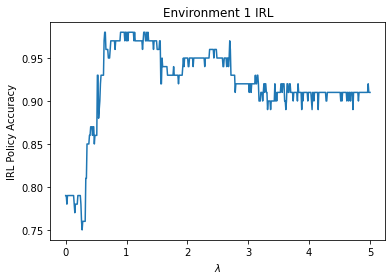

In [63]:
plt.plot(np.linspace(0,5,500),IRL_1_accuracy)
plt.xlabel("$\lambda$"); plt.ylabel("IRL Policy Accuracy"); plt.title("Environment 1 IRL")

In [93]:
lambda_best = np.linspace(0,5,500)[np.argmax(IRL_1_accuracy)]

In [97]:
c = get_c_block_matrices(environment1,lambda_best)
R_IRL = linear_solve_IRL(environment1,b,c,Ds).reshape(environment1.reward_space.shape)

environment_IRL = RL_environment(environment1.state_space,R_IRL,N_actions,w)
value_IRL,policy_IRL = value_iteration(environment_IRL,threshold,discount_factor)

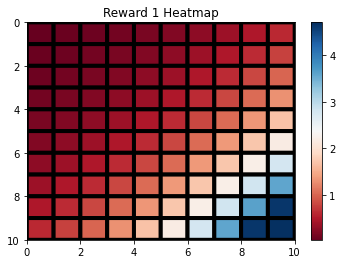

In [99]:
create_heatmap(V1,"Value from True Reward")

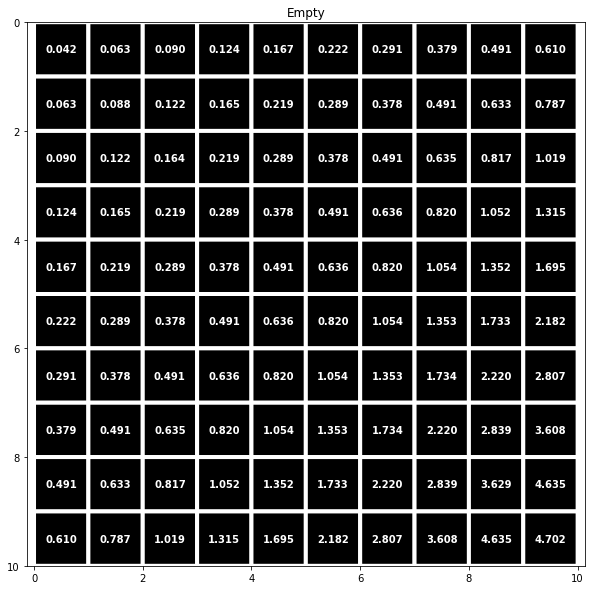

In [103]:
create_rewardmap(V1)

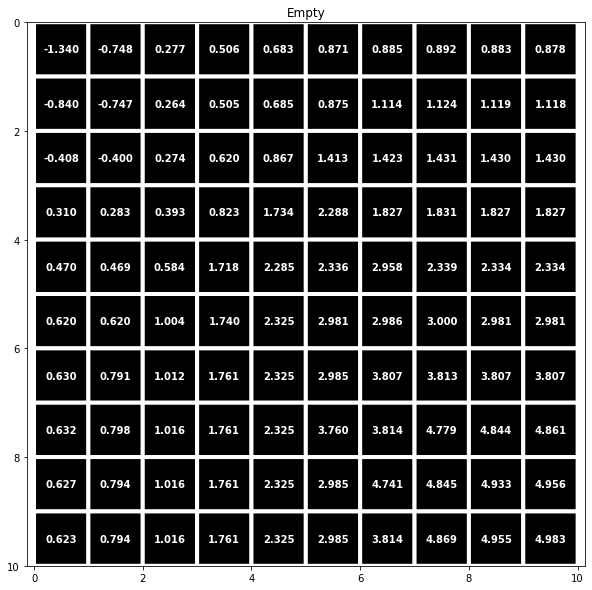

In [104]:
create_rewardmap(value_IRL)

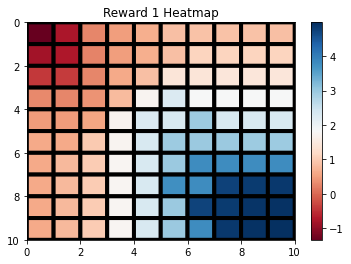

In [98]:
create_heatmap(value_IRL,"Value from IRL Reward")